# Estimating the Log Score: Leave One Out Cross Validation 

In the last tutorial, we discussed what scoring rules are and how they work, using the example of a logistic regression that evaluates whether a cat is mean or nice. We'll stick with that example here.

## Dealing with Cat Bias

In the last tutorial, we dealt with simple models that don't do any learning. While these models can crop up from time to time in basic physics, they're very rare. Most models have free parameters that they learn from the data. How can we compare them? 

Let's start by building two models that we can use as examples. We've assigned two veterinarian interns to write these models. Neither has much experience working with cats yet. They're eager to learn, though! Every time these interns see a new observation, they update on it using Bayes' theorem to get a new posterior density over our parameter values.

We'll use the same data as last time, with only one difference: Cats have different fur colors now.

In [15]:
using DataFrames
using ParetoSmooth
using LinearAlgebra
using Random
using StatsFuns
using StatsPlots
using Turing

In [16]:
Random.seed!(1776)  # Setting a seed for reproducibility
Turing.setprogress!(false)  # Turn off progress monitor.

n_cats = 1000  # Let's simulate 1000 cats!
percent_mean = 0.1  # In this simulation, 10% of cats are mean.
percent_scratched = 0.2  # 20% of cat owners have scratches.
# Having a mean cat increases the log-odds that the owner is scratched by 0.1.
relative_risk = 0.1  # this is about a 10% increase.


function colorful_cats(
    n_cats,
    percent_mean, 
    percent_scratched,
    percent_colors,
    relative_risk
)

    is_mean = Bool.(rand(Bernoulli(percent_mean), n_cats))

    # Fur color doesn't affect scratching or meanness
    cat_color = rand(Categorical(percent_colors), n_cats)

    logit_scratched = @. logit(percent_scratched) + relative_risk * (is_mean - percent_mean)
    scratched_owner = @. rand(BernoulliLogit(logit_scratched)) |> Bool

    # We can create a dummy variable, which always equals 1. 
    # This will make writing the models a bit easier later on.
    cat_exists = trues(n_cats)

    col_names = [:cat_exists, :scratched_owner, :color, :is_mean]
    columns = hcat(cat_exists, scratched_owner, cat_color, is_mean)
    return DataFrame(columns, col_names) 
end

percent_colors = [.2, .2, .2, .2, .2]

data = colorful_cats(
    n_cats, 
    percent_mean, 
    percent_scratched, 
    percent_colors, 
    relative_risk
)

┌ Info: [Turing]: progress logging is disabled globally
└ @ Turing /home/lime/.julia/packages/Turing/y0DW3/src/Turing.jl:22
┌ Info: [AdvancedVI]: global PROGRESS is set as false
└ @ AdvancedVI /home/lime/.julia/packages/AdvancedVI/yCVq7/src/AdvancedVI.jl:15


,cat_exists,scratched_owner,color,is_mean
,Int64,Int64,Int64,Int64
1,1,1,5,0
2,1,0,1,0
3,1,0,3,0
4,1,0,2,0
5,1,0,1,0
6,1,0,5,0
7,1,0,2,0
8,1,0,1,0
9,1,0,3,0


The first intern (correctly) realizes that fur color doesn't matter to niceness. The second intern thinks fur color does make a difference, because he's biased against orange cats. Maybe we should be testing this vet's meanness instead. >:(

In [17]:
x = Array(data[:, Not(:is_mean)])
y = data[:, :is_mean]

@model function intern_1(x, y)
    β_0 ~ Flat()
    β_scratching ~ Flat()
    regression = β_0 .+ β_scratching * x[:, :scratched_owner]
    @. y ~ BernoulliLogit(regression)
end


@model function intern_2(x, y)
    β_scratching ~ Flat()
    β_color ~ filldist(Flat(), 5)

    regression = β_scratching * x[:, :scratched_owner] .+ β_color[x[:, :color]]
    @. y ~ BernoulliLogit(regression)
end

intern_2 (generic function with 1 method)

┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference /home/lime/.julia/packages/Turing/y0DW3/src/inference/hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 0.4
└ @ Turing.Inference /home/lime/.julia/packages/Turing/y0DW3/src/inference/hmc.jl:188


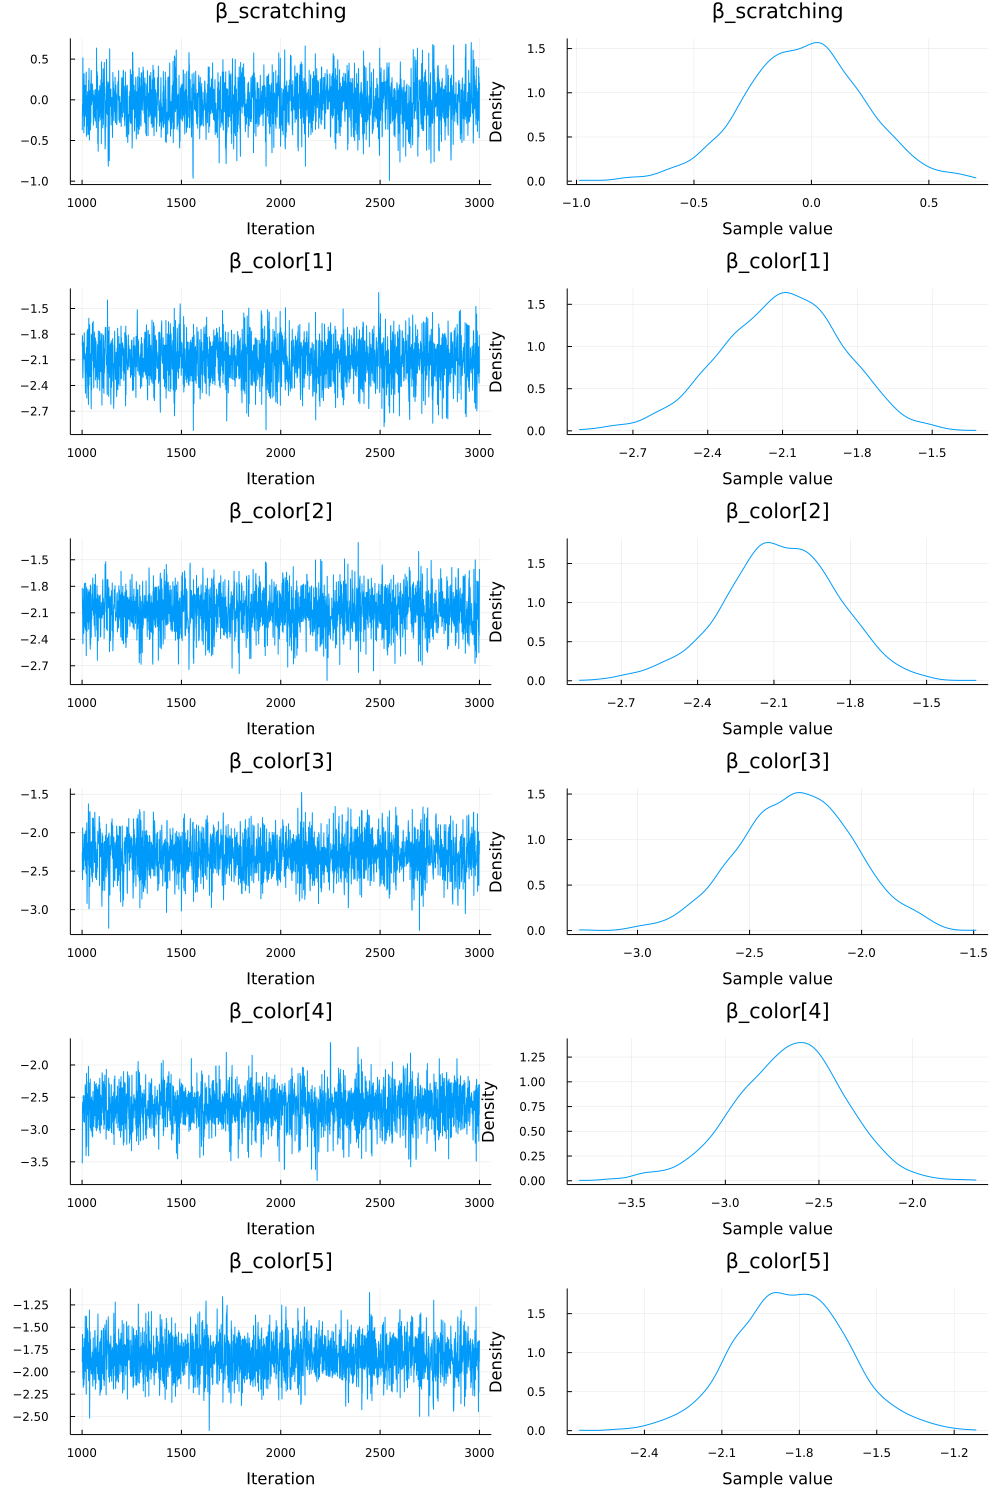

In [18]:
chains_1 = sample(intern_1(data, y), NUTS(), 2000)
plot(chains_1)

chains_2 = sample(intern_2(data, y), NUTS(), 2000)
plot(chains_2)

Looking at the plots for the two posteriors, we can see both models got pretty reasonable answers for `β_scratching`. However, the second model incorrectly assigns different colors different probabilities of being mean -- the posterior means for each color range from `-2.0` and `-2.5`, implying the second vet thinks that some fur colors are up to 50% more mean than others![^1] 

In [19]:
chains_2

Chains MCMC chain (2000×18×1 Array{Float64, 3}):

Iterations        = 1001:1:3000
Number of chains  = 1
Samples per chain = 2000
Wall duration     = 5.01 seconds
Compute duration  = 5.01 seconds
parameters        = β_color[2], β_color[4], β_color[1], β_color[3], β_color[5], β_scratching
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
    parameters      mean       std   naive_se      mcse         ess      rhat  ⋯
        Symbol   Float64   Float64    Float64   Float64     Float64   Float64  ⋯

  β_scratching   -0.0345    0.2549     0.0057    0.0061   1615.4718    1.0006  ⋯
    β_color[1]   -2.1053    0.2424     0.0054    0.0046   1934.6332    1.0012  ⋯
    β_color[2]   -2.0742    0.2224     0.0050    0.0059   1722.8841    0.9996  ⋯
    β_color[3]   -2.2924    0.2535     0.0057    0.0068   1914.5070    0.9995  ⋯
 

## The Naive Estimator

Clearly, the second model should score worse than the first model when we try comparing them. But adding up all those log-likelihood values sounds kind of painful. (Or maybe it's just the cat scratches.) Is there an easier way? Yes! The ParetoSmooth.jl package provides tools for easily comparing the goodness-of-fit of different models.

ParetoSmooth's `naive_lpd` command calculates the score of each model by breaking it down into two steps:
1. Update the model on all the data, so that we get the final model.
2. Assign the final model a score by adding the log-probability density (LPD for short) at each data point.

But if we try using `naive_lpd`, we immediately see a big problem:

In [20]:
hcat(
    ParetoSmooth.naive_lpd(intern_1(data, y), chains_1),
    ParetoSmooth.naive_lpd(intern_2(data, y), chains_2)
)

┌ Info: We advise against using `naive_lpd`, as it gives inconsistent and strongly biased estimates. Use `psis_loo` instead.
└ @ ParetoSmooth /home/lime/.julia/packages/ParetoSmooth/PtXtd/src/NaiveLPD.jl:13


┌ Info: We advise against using `naive_lpd`, as it gives inconsistent and strongly biased estimates. Use `psis_loo` instead.
└ @ ParetoSmooth /home/lime/.julia/packages/ParetoSmooth/PtXtd/src/NaiveLPD.jl:13


1×2 Matrix{Float64}:
 -335.932  -332.9

The second model has a higher score than the first one! (These are both negative numbers, so the less negative score is better.)

The reason for this comes down to how we estimated the scores. Let's imagine a very sneaky model that intentionally cheats to get a good score. This model assigns a probability of 100% to the exact data set we happened to get in this case, and a 0% probability to every other data set. This model will always get a perfect log score. It will get a perfect score even though it's just copying the data and is completely useless for making predictions.

In-sample estimators are very upward-biased for complex models with lots of parameters. This is because our model is learning from the data, so it picks parameters that fit the data well on purpose. This means ur parameters will always fit the data well, even if the parameters are completely meaningless or just flat-out wrong. This is why trying to use `naive_lpd` gives you a warning. *Never* use the naive estimate!

We call this problem, where models try too hard to fit the data, *overfitting*. Basically, models are huge try-hards, so they'll usually try too hard to fit the data. This will make them good at retrodicting data they already know about, but bad at predicting new data they haven't seen yet.

The estimate from `naive_lpd` is called the *in-sample* estimate of the log score, because we're measuring how well our model predicts *inside* the sample. What we really want, though, is a good estimator for the *out-of-sample* log score.

Unfortunately, it's impossible to completely get rid of overfitting; the only kind of model with zero overfitting is one that does zero fitting in the first place. That being said, there's some pretty good ways to reduce overfitting. To take advantage of these, though, we'll need to figure out how to estimate the out-of-sample log-score.

## Leave-One-Out Cross Validation

If the naive estimate is so bad, what's the alternative? The most common strategy is called *k-fold cross validation*. 

In k-fold cross validation, we split the data into `k` groups, or *folds*. We choose one group to be the training set and train the model using the other `k-1` folds. Then we see how well our model predicts the test set. We repeat this `k` times, then add up all these scores to get our final estimate.

<center>
<figure>
    <img src=https://miro.medium.com/max/788/1*AAwIlHM8TpAVe4l2FihNUQ.png width="700">
    <figcaption><i>A diagram showing 5-fold cross-validation, courtesy of <a href=https://towardsdatascience.com/cross-validation-k-fold-vs-monte-carlo-e54df2fc179b>Towards Data Science</a>.</i></figcaption>
</figure>
</center>

In this case, we'll use k-fold cross validation with `k` equal to the sample size, meaning every group has only one point in it. This is called leave-one-out cross validation (LOO-CV). LOO-CV gives us an unbiased estimate of the out-of-sample score. Because the training and test data are kept separate, our model can't cheat by overfitting to the test data -- it doesn't know what the test point will look like until it sees it!

There's one problem with LOO-CV: Computation time. Exactly calculating the LOO-CV score can take a very long time, since we'd need to refit the model for every single data point. To avoid this, ParetoSmooth.jl uses an approximate algorithm called Pareto-smoothed importance sampling. This lets us estimate the LOO-CV score without having to draw more samples from the posterior distribution. Let's try it out!

In [21]:
loo_scores = vcat(
    psis_loo(intern_1(data, y), chains_1),
    psis_loo(intern_2(data, y), chains_2)
)

┌ Info: Adjusting for autocorrelation. If the posterior samples are not autocorrelated, specify the source of the posterior sample using the keyword argument `source`. MCMC samples are always autocorrelated; VI samples are not.
└ @ ParetoSmooth /home/lime/.julia/packages/ParetoSmooth/PtXtd/src/InternalHelpers.jl:38


┌ Info: Adjusting for autocorrelation. If the posterior samples are not autocorrelated, specify the source of the posterior sample using the keyword argument `source`. MCMC samples are always autocorrelated; VI samples are not.
└ @ ParetoSmooth /home/lime/.julia/packages/ParetoSmooth/PtXtd/src/InternalHelpers.jl:38


2-element Vector{PsisLoo{Float64, Array{Float64, 3}, Vector{Float64}}}:
 
 

Results of PSIS-LOO-CV with 2000 Monte Carlo samples and 1000 data points. Total Monte Carlo SE of 0.043.
┌───────────┬─────────┬──────────┬───────┬─────────┐
│           │   total │ se_total │  mean │ se_mean │
├───────────┼─────────┼──────────┼───────┼─────────┤
│   cv_elpd │ -337.91 │    20.96 │ -0.34 │    0.02 │
│ naive_lpd │ -335.93 │    20.80 │ -0.34 │    0.02 │
│     p_eff │    1.98 │     0.21 │  0.00 │    0.00 │
└───────────┴─────────┴──────────┴───────┴─────────┘
Results of PSIS-LOO-CV with 2000 Monte Carlo samples and 1000 data points. Total Monte Carlo SE of 0.057.
┌───────────┬─────────┬──────────┬───────┬─────────┐
│           │   total │ se_total │  mean │ se_mean │
├───────────┼─────────┼──────────┼───────┼─────────┤
│   cv_elpd │ -339.08 │    21.21 │ -0.34 │    0.02 │
│ naive_lpd │ -332.90 │    20.69 │ -0.33 │    0.02 │
│     p_eff │    6.18 │     0.54 │  0.01 │    0.00 │
└───────────┴─────────┴──────────┴───────┴─────────┘


Now we can see the benefits of leave-one-out cross validation: The first model has a much better out-of-sample score than the second model. 

Along the left hand side, we can see three rows: 
1. `cv_elpd`, which tells us the *cross-validation* estimate of the *expected log probability density*.
2. `naive_lpd`, which we've already discussed.
3. `p_eff`, the effective number of parameters. This is the difference between the first two estimates. If you set flat priors, this will equal the number of parameters in your model. However, if you set good priors, each parameter will add less than 1 point to `p_eff`. A good prior will reduce overfitting, because it brings in information from outside of the data. This extra information makes it easier for the model to tell the difference between random noise and a real signal in the data.

The `total` column tells us the sum of the scores for all the data points, while the `mean` column tells us the average score per data point. `se_total` and `se_mean` tell us the standard error in each of these estimates.

Apart from `p_eff`, all of these numbers are *completely* meaningless on their own, because they're only defined up to a constant. 

For instance, let's say you're trying to predict someone's height. If someone took all the numbers in your data and converted the outcomes from meters to centimeters, you'd suddenly see the `naive_lpd` and `cv_elpd` columns increase by `log(100)=4.6` points, even though nothing really changed.

However, *differences* in log scores are very meaningful. That's why we have the `loo_compare` function, which can compare several models at once by taking the differences in `cv_elpd`:

In [22]:
loo_compare(loo_scores)

┌─────────┬─────────┬────────┬────────┐
│         │ cv_elpd │ cv_avg │ weight │
├─────────┼─────────┼────────┼────────┤
│ model_1 │    0.00 │  -0.34 │   0.76 │
│ model_2 │   -1.16 │  -0.34 │   0.24 │
└─────────┴─────────┴────────┴────────┘


This table compares every model to the one with the best score. The table has one other important piece of information: It provides a set of weights, called Akaike weights[^2], that can be used for model averaging. These weights are *not* posterior probabilities in the Bayesian sense. Instead, these weights are proportional to `exp(ELPD)`. By averaging several models, we can smooth out some of the random variation in how well each model performs.[^3]

## K-Fold Cross Validation

At this point, some of you might be asking whether we should only leave out one data point at a time. Maybe this doesn't affect our estimates enough, and we'll still get overfitting.

This is a real problem with traditional machine learning techniques and loss functions. However, Bayesian models and the Bayes score are more sensitive to small changes in the sample because they avoid generating estimates as an intermediate step, and instead compare models directly with the predictive density. Generating estimates throws away information, so two models can have very different ELPD scores even if they produce similar estimates.

Leave-one-out cross validation is the best choice for comparing Bayesian models for two reasons:
1. Lower bias. A model trained on a bigger dataset will get a better score, since it has more data to learn from. We want to test how well the full model, trained on `n` data points, will predict outputs from outside the model. Because of that, the best way would be to train our model on exactly `n` data points, which would give us a model that does about as well on average as our real model. We can't do that, though, since training the model on a sample of size `n` would leave us without any test points. The closest we can get is training the model on `n-1` points, so we do that instead.
2. Lower variance. The more folds we have, the lower the variance gets, since it lowers the chances that a single bad fold can mess up our predictions. Having `n` folds maximizes the number of folds.

When training Bayesian models with the ELPD, leave-one-out is the best choice. However, leave-one-out cross validation can take a long time for large datasets. In the future, we plan to introduce other tools for reducing this compuatational cost.

### Taking Good Care of Your Approximation

It is important to take good care of your <s>cat</s> approximate LOO-CV score. ParetoSmooth.jl relies on a specific sampling algorithm called Pareto Smoothed Importance Sampling, or PSIS for short. 

To estimate the LOO-CV score, we need to take one data point out of the training set to get a new posterior distribution. Let's call this the LOO posterior. Now we have to repeat this for `n` LOO posteriors, where `n` is the number of data points, and draw a posterior sample from each of them. That's a lot of posterior samples!

The good news is there's a way to cheat. The LOO posterior is usually very similar to the full posterior distribution. PSIS takes the chains you've already sampled from the original posterior, then adjusts them by reweighting the samples to match the leave-one-out posteriors. This saves a *lot* of time and effort. Hooray for cheating!

Here's the bad news: if we have outliers, this approximation doesn't work, because some of the leave-one-out posteriors are very different from the full posteriors. :(
    
But there's other good news! Much like a top-tier scientist, PSIS can tell us when it's screwed up. (We're still working on getting it to apologize). Let's try calculating the ELPD with PSIS again, but using a trickier data set. Here we'll use a very small sample, meaning that some fur colors will be very rare.

In [23]:
smol_data = colorful_cats(
    200, 
    percent_mean, 
    percent_scratched, 
    percent_colors,
    relative_risk
)

smol_chain = sample(intern_2(smol_data, smol_data[:, :is_mean]), NUTS(), 10000)
smol_scores = psis_loo(intern_2(smol_data, smol_data[:, :is_mean]), smol_chain)

┌ Info: Found initial step size
│   ϵ = 0.8
└ @ Turing.Inference /home/lime/.julia/packages/Turing/y0DW3/src/inference/hmc.jl:188
┌ Info: Adjusting for autocorrelation. If the posterior samples are not autocorrelated, specify the source of the posterior sample using the keyword argument `source`. MCMC samples are always autocorrelated; VI samples are not.
└ @ ParetoSmooth /home/lime/.julia/packages/ParetoSmooth/PtXtd/src/InternalHelpers.jl:38


Results of PSIS-LOO-CV with 10000 Monte Carlo samples and 200 data points. Total Monte Carlo SE of 0.17.
┌───────────┬────────┬──────────┬───────┬─────────┐
│           │  total │ se_total │  mean │ se_mean │
├───────────┼────────┼──────────┼───────┼─────────┤
│   cv_elpd │ -59.44 │    11.30 │ -0.30 │    0.06 │
│ naive_lpd │ -51.05 │     9.01 │ -0.26 │    0.05 │
│     p_eff │   8.39 │     2.72 │  0.04 │    0.01 │
└───────────┴────────┴──────────┴───────┴─────────┘


┌ Warning: Some Pareto k values are high (>.7), indicating that PSIS has failed to approximate the true distribution.
└ @ ParetoSmooth /home/lime/.julia/packages/ParetoSmooth/PtXtd/src/InternalHelpers.jl:71


Hooray for PSIS! Pay attention to these warnings -- they tell us when not to trust the results!

## Footnotes

[^1]: Despite the large sample, some of these differences would be borderline significant under a classical t-test -- colors 2+3 differ by about 2 standard deviations! This is one reason why regularizing priors are important: Our second vet used a flat prior, so he's way too willing to generalize from the handful of mean cats he's seen.

[^2]: The name "Akaike weights" comes from the Akaike Information Criterion, which is a commonly-used estimator of the ELPD. The Akaike Information Criterion and LOO-CV are asymptotically equivalent, i.e. they will agree for large samples. However, LOO-CV is more robust, has a smaller bias, and uses the full posterior distribution instead of comparing different estimators.

[^3]: If you've ever worked with inverse variance weights before, Akaike weights generalize inverse variance weights to cases where we use the ELPD instead of the mean squared error.

In [24]:
if isdefined(Main, :TuringTutorials)
    Main.TuringTutorials.tutorial_footer(WEAVE_ARGS[:folder], WEAVE_ARGS[:file])
end